An attempt at analysis of Wikipedia articles' titles. The goal was to practice NLP skills learnt with [DataCamp's live coding session](https://www.datacamp.com/community/tutorials/web-scraping-python-nlp). Instead of web scraping I used a dataset found on [Kaggle](https://www.kaggle.com/residentmario/wikipedia-article-titles), which in turn allowed me to practice some data cleaning. 

In [1]:
import pandas as pd
import re

from nltk.tokenize import RegexpTokenizer
import nltk


import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# reading in the data
df = pd.read_csv('titles.csv', sep='\n')

In [3]:
df.head()

,!
0,!!
1,!!!
2,!!!Fuck_You!!!
3,!!!Fuck_You!!!_And_Then_Some
4,!!!Fuck_You!!!_and_Then_Some


Well this starts nice. 

In [4]:
df.columns = ['articles']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14846974 entries, 0 to 14846973
Data columns (total 1 columns):
articles    object
dtypes: object(1)
memory usage: 113.3+ MB


In [6]:
# starting with duplicates drop to avoid unnecessary processing
df.drop_duplicates(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13441690 entries, 0 to 13441692
Data columns (total 1 columns):
articles    object
dtypes: object(1)
memory usage: 205.1+ MB


In [8]:
# changing all row values to strings
df.articles = df.articles.apply(str)

In [9]:
# using lower on each row to remove values differing only by case
df.articles = [article.lower() for article in df.articles]

In [10]:
# changing data frame to a list, it will allow quick list comprehensions
articles = df.articles.tolist()
articles = list(set(articles))
len(articles)

12675109

In [11]:
# changing underscores to spaces
articles = [re.sub('_', ' ', article) for article in articles]

In [12]:
# removing special-characters-only rows
articles = [re.sub('[^A-Za-z0-9\s]+', '', article) for article in articles]

In [13]:
articles[:10]

['north american yale',
 'carib expulsion',
 'lady frederick windsor',
 'asakawa',
 '27s wonderful 27s marvelous',
 'toshirc58d yabuki',
 'keybank na',
 'pull inventory',
 'muetzenich',
 'sh 50 co']

In [14]:
# removing empty strings left
final_articles = [article for article in articles if article != '']

In [15]:
# removing unnecessary spaces
final_articles = [article.strip() for article in final_articles]

In [16]:
final_articles[:10]

['north american yale',
 'carib expulsion',
 'lady frederick windsor',
 'asakawa',
 '27s wonderful 27s marvelous',
 'toshirc58d yabuki',
 'keybank na',
 'pull inventory',
 'muetzenich',
 'sh 50 co']

In [17]:
len(final_articles)

12675048

The data is now in much nicer and cleaner shape. We're down from 14846974 entries to 12675048. Now I am going to prepare the data to tokenize it.

In [18]:
# splitting each article so that in next steps I can create one string of all the text
all_lines = [article.split(' ') for article in final_articles]

In [19]:
all_lines[:10]

[['north', 'american', 'yale'],
 ['carib', 'expulsion'],
 ['lady', 'frederick', 'windsor'],
 ['asakawa'],
 ['27s', 'wonderful', '27s', 'marvelous'],
 ['toshirc58d', 'yabuki'],
 ['keybank', 'na'],
 ['pull', 'inventory'],
 ['muetzenich'],
 ['sh', '50', 'co']]

In [20]:
all_words = ' '.join(word for line in all_lines for word in line if word != '')

In [21]:
len(all_words)

264798310

In [22]:
all_words[:1]

'n'

In [23]:
# tokenizing words
tokenizer = RegexpTokenizer('\w+')
tokens = tokenizer.tokenize(all_words)
print(tokens[:5])

['north', 'american', 'yale', 'carib', 'expulsion']


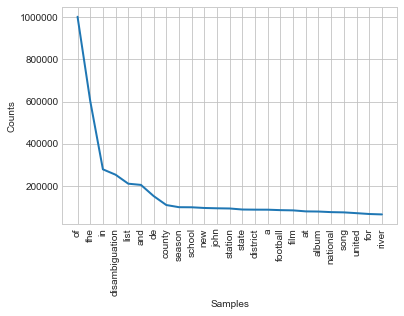

In [24]:
# Create freq dist and plot
freqdist1 = nltk.FreqDist(tokens)
freqdist1.plot(25)

Although the titles are in different languages, the top words include numerous English stopwords. It will be a good idea to remove them, as they carry no meaning.

In [25]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')
sw[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dorotamierzwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

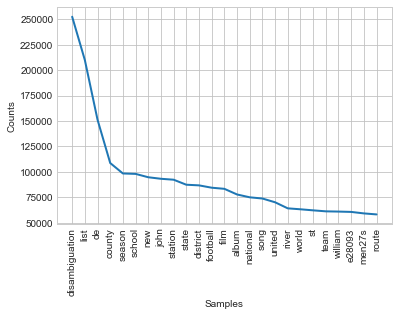

In [26]:
all_no_stopwords = []
for word in tokens:
    if word not in sw:
        all_no_stopwords.append(word)

freqdist2 = nltk.FreqDist(all_no_stopwords)
freqdist2.plot(25)

In [27]:
freqdist2.most_common(25)

[('disambiguation', 252482),
 ('list', 209900),
 ('de', 151223),
 ('county', 108647),
 ('season', 98386),
 ('school', 97969),
 ('new', 94664),
 ('john', 93155),
 ('station', 92245),
 ('state', 87314),
 ('district', 86689),
 ('football', 84383),
 ('film', 83283),
 ('album', 77742),
 ('national', 74942),
 ('song', 73761),
 ('united', 70054),
 ('river', 64091),
 ('world', 63162),
 ('st', 62123),
 ('team', 61150),
 ('william', 60910),
 ('e28093', 60579),
 ('men27s', 59122),
 ('route', 58120)]

Cool, it works! The most popular words in Wikipedia articles titles is listed above. The most common is 'disambiguation' which is Wikipedia's way to group similiar or same names that refer to different subjects.

I thought it didn't turn out to be very interesting so below I created a function that searches for most popular words that accompany a given search word. First thing I looked at was what are the words accompanying 'Poland' and 'Polska' ('Poland' in Polish). Are there differences in the Wikipedia pages that refer to Poland on an international level than those we have only in our own language?

In [28]:
def contextWords(search_word, list_of_strings):
    '''
    Takes a string as an argument and checks it's presence in each string from a given list.
    Returns a frequency distribution plot of words that accompany the search word in all strings, excluding English 
    stopwords.
    '''
    search_list = [word for word in list_of_strings if re.findall(search_word, word)]
    search_words = []
    for expression in search_list:
        for w in expression.split(' '):
            if w not in nltk.corpus.stopwords.words('english'):
                search_words.append(w)
    new_search_words = ' '.join(word for word in search_words if word != '')
    new_tokens = tokenizer.tokenize(new_search_words)
    search_freqdist = nltk.FreqDist(new_tokens)
    search_freqdist.plot(20)    

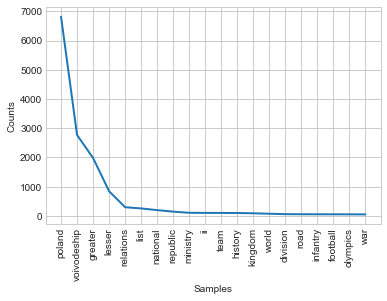

In [29]:
contextWords('poland', final_articles)

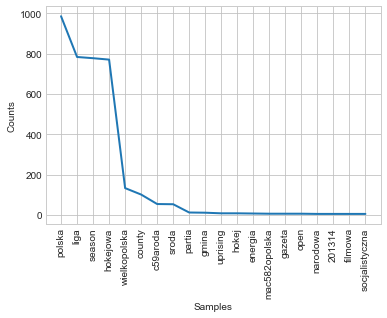

In [30]:
contextWords('polska', final_articles)

I'm finding this quite surprising. In English version we see a lot of neutral words such as: voivoidship (regional unit), national, greater and lesser (which constitute some of the voivodship names). Some words corresponding to Poland's history: kingdom, republic, infantry, war. On the other hand the Polish version is what I find really interesting, as it includes hockey twice! I wouldn't guess this is the one sport to be associated with Poland. Other than that there are: league, uprising, energy, newspaper, national, movie and socialistic and some administrative units' names.

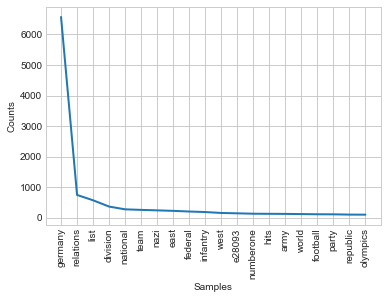

In [31]:
contextWords('germany', final_articles)

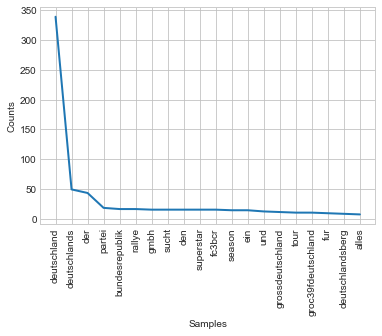

In [32]:
contextWords('deutschland', final_articles)

English version of articles with 'Germany' include a lot of historical connotations: nazi, east, west, infantry, army, whereas German version include none of such words. Most common words in articles' titles are then, except for stopwords: party, rally, addiction, superstar, gmbh (l.l.c.), season and a few geographical terms. This creates a significant contrast.

Let's look at some more!

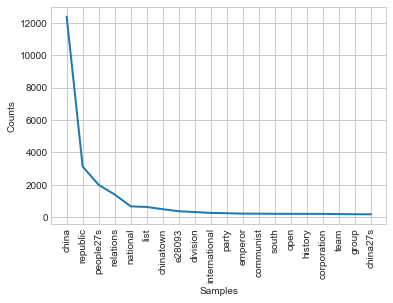

In [33]:
contextWords('china', final_articles)

Is python more often referred to as an animal or programming language?

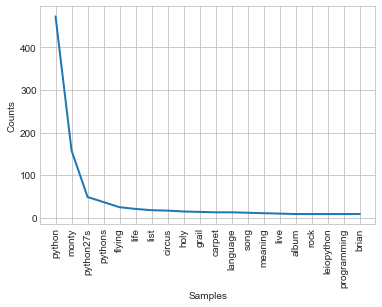

In [34]:
contextWords('python', final_articles)

Ok I lost and Monty Python won. But out of my two guesses we get 'language' and 'programming' so maybe I got a few points for that.